# 论文30：迷失在中间：语言模型如何使用长上下文
## Nelson F. Liu, Kevin Lin, John Hewitt, et al., Stanford & UW (2023)

### "迷失在中间"现象

语言模型难以使用长上下文中间部分的信息。性能呈现 U 型曲线！

In [1]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)

# 设置中文字体
plt.rcParams["font.family"] = ["Heiti TC"]
plt.rcParams["axes.unicode_minus"] = False

## 模拟多文档 QA 任务

**设置**： 
- 查询需要来自一个文档的信息
- 提供多个文档（1 个相关，其余为干扰项）
- **问题**：相关文档的位置是否重要？

In [2]:
class Document:
    def __init__(self, content, is_relevant=False):
        self.content = content
        self.is_relevant = is_relevant
    
    def __repr__(self):
        return f"Doc(relevant={self.is_relevant}): {self.content[:50]}..."

# Create synthetic documents
relevant_doc = Document(
    "The Eiffel Tower was completed in 1889 and stands 330 meters tall. "
    "It was designed by Gustave Eiffel for the 1889 World's Fair in Paris.",
    is_relevant=True
)

distractor_docs = [
    Document("The Great Wall of China is over 13,000 miles long and was built over many centuries."),
    Document("The Statue of Liberty was gifted by France to the United States in 1886."),
    Document("Mount Everest is the tallest mountain on Earth at 8,849 meters above sea level."),
    Document("The Amazon River is the largest river by discharge volume in the world."),
    Document("The Sahara Desert is the largest hot desert, covering much of North Africa."),
    Document("The Colosseum in Rome was completed in 80 AD and could hold 50,000 spectators."),
    Document("The Taj Mahal in India was built between 1632 and 1653 as a mausoleum."),
    Document("The Grand Canyon in Arizona is 277 miles long and up to 18 miles wide."),
    Document("The Great Barrier Reef is the world's largest coral reef system."),
]

query = "When was the Eiffel Tower completed?"
correct_answer = "1889"

print(f"Query: {query}")
print(f"Correct answer: {correct_answer}")
print(f"\nRelevant document: {relevant_doc.content}")
print(f"\nNumber of distractor documents: {len(distractor_docs)}")

Query: When was the Eiffel Tower completed?
Correct answer: 1889

Relevant document: The Eiffel Tower was completed in 1889 and stands 330 meters tall. It was designed by Gustave Eiffel for the 1889 World's Fair in Paris.

Number of distractor documents: 9


## 简化的语言模型

模拟带位置偏差的基于注意力的模型

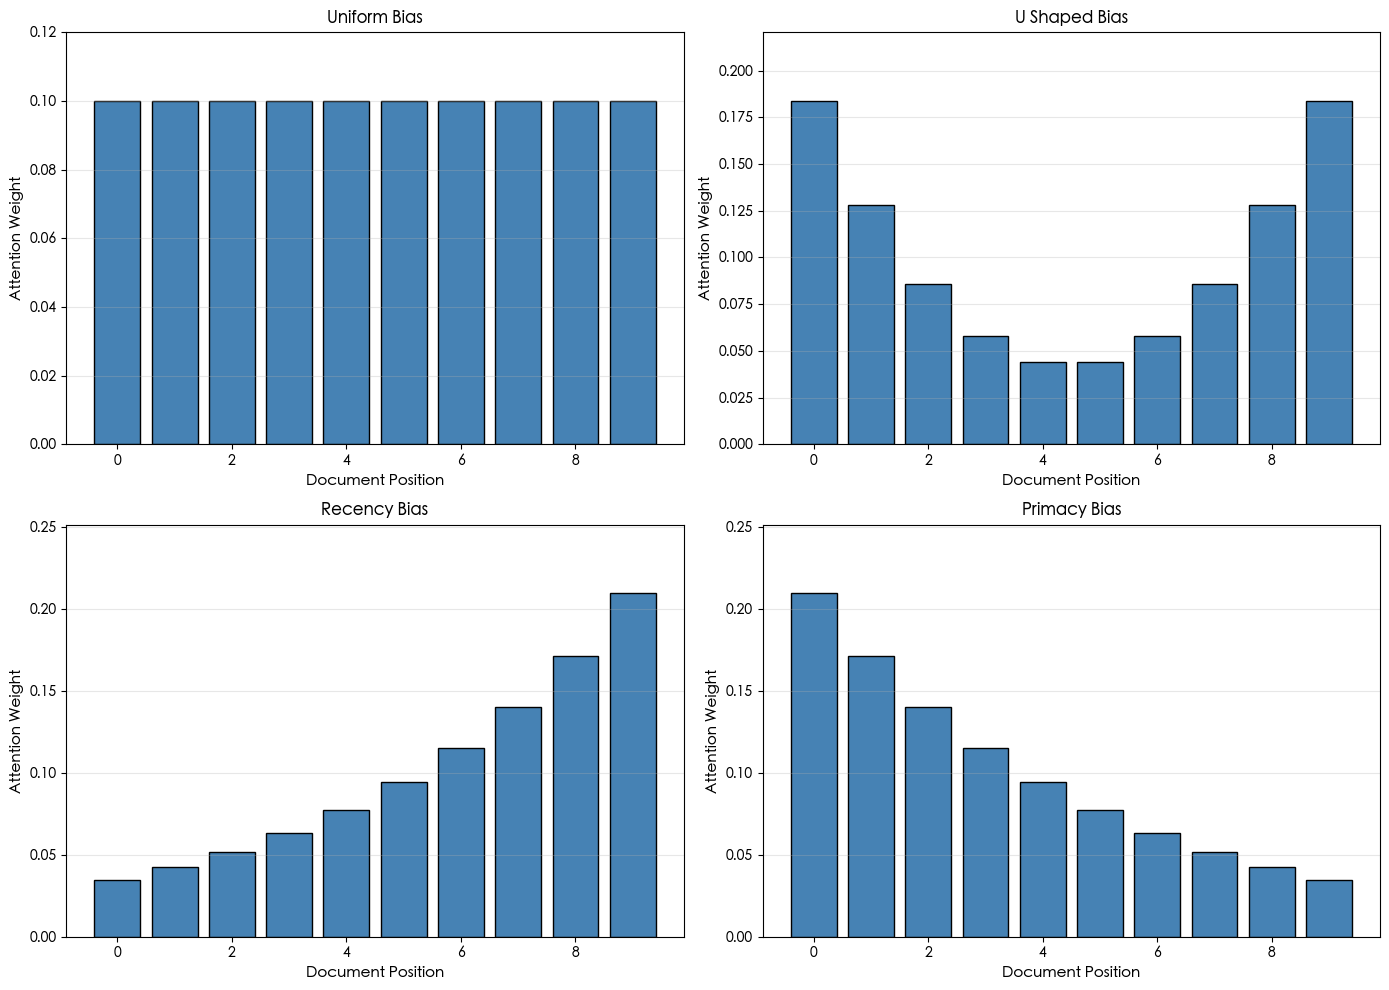


真实的 LLM 显示 U 型偏差（开始/结束处高，中间低）！


In [3]:
class SimpleLM:
    """带位置偏差的简化 LM"""
    def __init__(self, position_bias_type='u_shaped'):
        """
        position_bias_type:
        - 'uniform': 对所有位置给予相等的注意力
        - 'u_shaped': 在开始/结束处高，中间低
        - 'recency': 偏好最近（结束）位置
        - 'primacy': 偏好早期（开始）位置
        """
        self.position_bias_type = position_bias_type
    
    def get_position_weights(self, num_positions):
        """计算基于位置的注意力权重"""
        positions = np.arange(num_positions)
        
        if self.position_bias_type == 'uniform':
            weights = np.ones(num_positions)
        
        elif self.position_bias_type == 'u_shaped':
            # U 型：边缘高，中间低
            normalized_pos = positions / (num_positions - 1)  # 0 到 1
            # 在 0.5 处有最小值的二次函数
            weights = 4 * (normalized_pos - 0.5) ** 2 + 0.3
        
        elif self.position_bias_type == 'recency':
            # 向开始处指数衰减
            weights = np.exp(positions * 0.2)
        
        elif self.position_bias_type == 'primacy':
            # 向结束处指数衰减
            weights = np.exp(-positions * 0.2)
        
        # 归一化
        weights = weights / np.sum(weights)
        return weights
    
    def answer_query(self, query, documents):
        """
        模拟使用文档回答查询
        返回：找到正确答案的概率
        """
        num_docs = len(documents)
        
        # 获取位置权重
        position_weights = self.get_position_weights(num_docs)
        
        # 找到相关文档位置
        relevant_position = None
        for i, doc in enumerate(documents):
            if doc.is_relevant:
                relevant_position = i
                break
        
        if relevant_position is None:
            return 0.0  # 没有相关文档
        
        # 使用相关文档的概率
        # 权重越高 → 越可能使用该文档
        prob_correct = position_weights[relevant_position]
        
        return prob_correct

# 测试不同的偏差类型
num_docs = 10
test_positions = np.arange(num_docs)

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

bias_types = ['uniform', 'u_shaped', 'recency', 'primacy']
for ax, bias_type in zip(axes, bias_types):
    model = SimpleLM(position_bias_type=bias_type)
    weights = model.get_position_weights(num_docs)
    
    ax.bar(test_positions, weights, color='steelblue', edgecolor='black')
    ax.set_xlabel('Document Position', fontsize=11)
    ax.set_ylabel('Attention Weight', fontsize=11)
    ax.set_title(f'{bias_type.replace("_", " ").title()} Bias', fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3, axis='y')
    ax.set_ylim(0, max(weights) * 1.2)

plt.tight_layout()
plt.show()

print("\n真实的 LLM 显示 U 型偏差（开始/结束处高，中间低）！")

## 测试位置敏感性

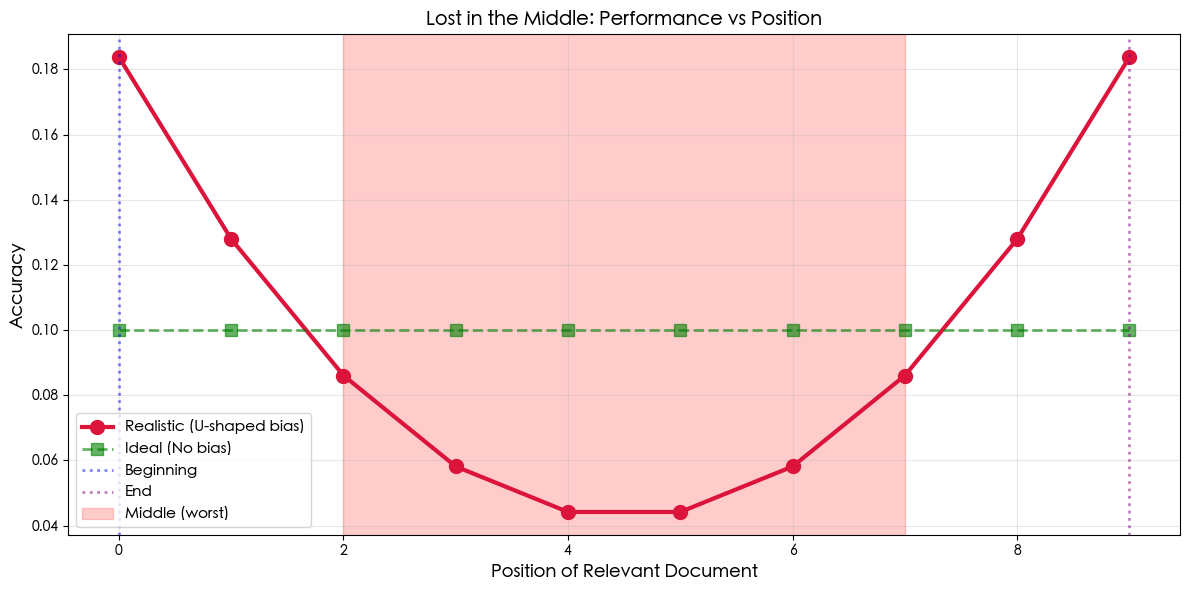


Performance Analysis:
Beginning (pos 0): 18.4%
Middle (pos 2-7): 5.8%
End (pos 9): 18.4%

Middle penalty: -68.4% relative to beginning


In [4]:
def test_all_positions(model, query, relevant_doc, distractor_docs):
    """
    Test performance with relevant document at each position
    """
    num_positions = len(distractor_docs) + 1
    accuracies = []
    
    for pos in range(num_positions):
        # Create document list with relevant doc at position 'pos'
        docs = distractor_docs[:pos] + [relevant_doc] + distractor_docs[pos:]
        docs = docs[:num_positions]  # Keep fixed length
        
        # Get model's probability of answering correctly
        prob_correct = model.answer_query(query, docs)
        accuracies.append(prob_correct)
    
    return accuracies

# Test U-shaped bias (realistic)
model_realistic = SimpleLM(position_bias_type='u_shaped')
accuracies_realistic = test_all_positions(model_realistic, query, relevant_doc, distractor_docs)

# Test uniform (ideal)
model_ideal = SimpleLM(position_bias_type='uniform')
accuracies_ideal = test_all_positions(model_ideal, query, relevant_doc, distractor_docs)

# Plot
positions = np.arange(len(accuracies_realistic))

plt.figure(figsize=(12, 6))
plt.plot(positions, accuracies_realistic, 'o-', linewidth=3, markersize=10, 
        label='Realistic (U-shaped bias)', color='crimson')
plt.plot(positions, accuracies_ideal, 's--', linewidth=2, markersize=8, 
        label='Ideal (No bias)', color='green', alpha=0.6)

# Mark beginning and end
plt.axvline(x=0, color='blue', linestyle=':', alpha=0.5, linewidth=2, label='Beginning')
plt.axvline(x=len(positions)-1, color='purple', linestyle=':', alpha=0.5, linewidth=2, label='End')

# Mark middle region
middle_start = len(positions) // 4
middle_end = 3 * len(positions) // 4
plt.axvspan(middle_start, middle_end, alpha=0.2, color='red', label='Middle (worst)')

plt.xlabel('Position of Relevant Document', fontsize=13)
plt.ylabel('Accuracy', fontsize=13)
plt.title('Lost in the Middle: Performance vs Position', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Stats
beginning_acc = accuracies_realistic[0]
middle_acc = np.mean(accuracies_realistic[middle_start:middle_end])
end_acc = accuracies_realistic[-1]

print(f"\nPerformance Analysis:")
print(f"Beginning (pos 0): {beginning_acc:.1%}")
print(f"Middle (pos {middle_start}-{middle_end}): {middle_acc:.1%}")
print(f"End (pos {len(positions)-1}): {end_acc:.1%}")
print(f"\nMiddle penalty: -{(beginning_acc - middle_acc)/beginning_acc:.1%} relative to beginning")

## 上下文长度的影响

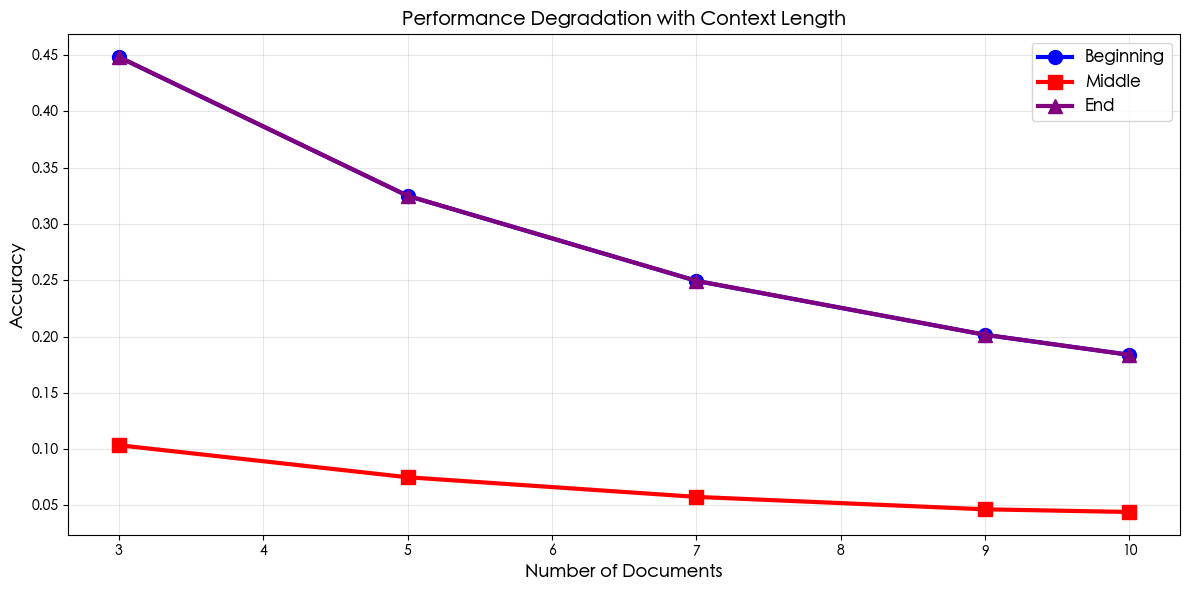


更长的上下文 → 更差的性能（尤其是在中间！）


In [5]:
def test_varying_lengths(model, query, relevant_doc, distractor_docs, lengths):
    """
    测试性能如何随上下文长度变化
    """
    results = {'beginning': [], 'middle': [], 'end': []}
    
    for length in lengths:
        # 使用干扰项的子集
        current_distractors = distractor_docs[:length-1]
        
        # 测试三个位置：开始、中间、结束
        positions = {
            'beginning': 0,
            'middle': length // 2,
            'end': length - 1
        }
        
        for pos_name, pos in positions.items():
            docs = current_distractors[:pos] + [relevant_doc] + current_distractors[pos:]
            docs = docs[:length]
            
            acc = model.answer_query(query, docs)
            results[pos_name].append(acc)
    
    return results

# 测试不同的上下文长度
lengths = [3, 5, 7, 9, 10]
results = test_varying_lengths(model_realistic, query, relevant_doc, distractor_docs, lengths)

# 绘制
plt.figure(figsize=(12, 6))
plt.plot(lengths, results['beginning'], 'o-', linewidth=3, markersize=10, 
        label='Beginning', color='blue')
plt.plot(lengths, results['middle'], 's-', linewidth=3, markersize=10, 
        label='Middle', color='red')
plt.plot(lengths, results['end'], '^-', linewidth=3, markersize=10, 
        label='End', color='purple')

plt.xlabel('Number of Documents', fontsize=13)
plt.ylabel('Accuracy', fontsize=13)
plt.title('Performance Degradation with Context Length', fontsize=14, fontweight='bold')
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\n更长的上下文 → 更差的性能（尤其是在中间！）")

## RAG 的排序策略


default                  : Relevant doc at position  2, Accuracy: 8.6%

most_relevant_first      : Relevant doc at position  0, Accuracy: 18.4%

most_relevant_edges      : Relevant doc at position  0, Accuracy: 18.4%


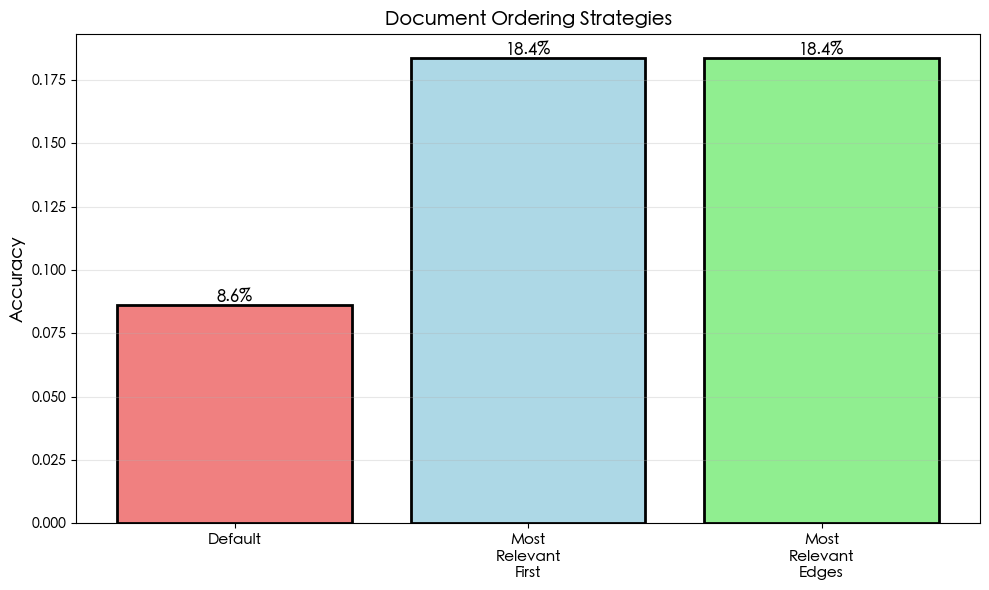


RECOMMENDATION: Put most important documents at edges!


In [6]:
def order_documents(documents, relevance_scores, strategy='default'):
    """
    根据策略对文档进行排序
    
    策略：
    - 'default': 保持检索顺序
    - 'most_relevant_first': 将最佳文档放在开始
    - 'most_relevant_edges': 将最佳文档放在开始和结束
    - 'reverse': 反转检索顺序
    """
    indices = np.arange(len(documents))
    
    if strategy == 'default':
        return documents
    
    elif strategy == 'most_relevant_first':
        # 按相关性排序（降序）
        sorted_indices = np.argsort(relevance_scores)[::-1]
        return [documents[i] for i in sorted_indices]
    
    elif strategy == 'most_relevant_edges':
        # 将最相关的放在开始和结束
        sorted_indices = np.argsort(relevance_scores)[::-1]
        
        # 交错：最佳在边缘，最差在中间
        ordered = []
        for i in range(len(documents) // 2):
            ordered.append(documents[sorted_indices[i]])  # 高相关性
        for i in range(len(documents) // 2, len(documents)):
            ordered.append(documents[sorted_indices[i]])  # 低相关性
        
        # 反转后半部分以将高相关性放在末尾
        mid = len(ordered) // 2
        return ordered[:mid] + ordered[mid:][::-1]
    
    elif strategy == 'reverse':
        return documents[::-1]
    
    return documents

# Simulate retrieval scores
num_test_docs = 10
test_docs = [relevant_doc] + distractor_docs[:num_test_docs-1]

# Relevance scores (relevant doc gets high score)
relevance_scores = np.random.rand(num_test_docs) * 0.5
relevance_scores[0] = 0.95  # Relevant doc has high score

# Shuffle to simulate retrieval
shuffle_idx = np.random.permutation(num_test_docs)
test_docs = [test_docs[i] for i in shuffle_idx]
relevance_scores = relevance_scores[shuffle_idx]

# Test different strategies
strategies = ['default', 'most_relevant_first', 'most_relevant_edges']
strategy_accuracies = {}

for strategy in strategies:
    ordered = order_documents(test_docs, relevance_scores, strategy)
    acc = model_realistic.answer_query(query, ordered)
    strategy_accuracies[strategy] = acc
    
    # Find position of relevant doc
    rel_pos = next(i for i, doc in enumerate(ordered) if doc.is_relevant)
    print(f"\n{strategy:25s}: Relevant doc at position {rel_pos:2d}, Accuracy: {acc:.1%}")

# Visualize
plt.figure(figsize=(10, 6))
bars = plt.bar(range(len(strategies)), 
              [strategy_accuracies[s] for s in strategies],
              color=['lightcoral', 'lightblue', 'lightgreen'],
              edgecolor='black', linewidth=2)

plt.xticks(range(len(strategies)), 
          [s.replace('_', '\n').title() for s in strategies],
          fontsize=11)
plt.ylabel('Accuracy', fontsize=13)
plt.title('Document Ordering Strategies', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3, axis='y')

# Add value labels
for bar, strategy in zip(bars, strategies):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
            f'{strategy_accuracies[strategy]:.1%}',
            ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

print("\n" + "="*60)
print("RECOMMENDATION: Put most important documents at edges!")
print("="*60)

## 注意力模式分析

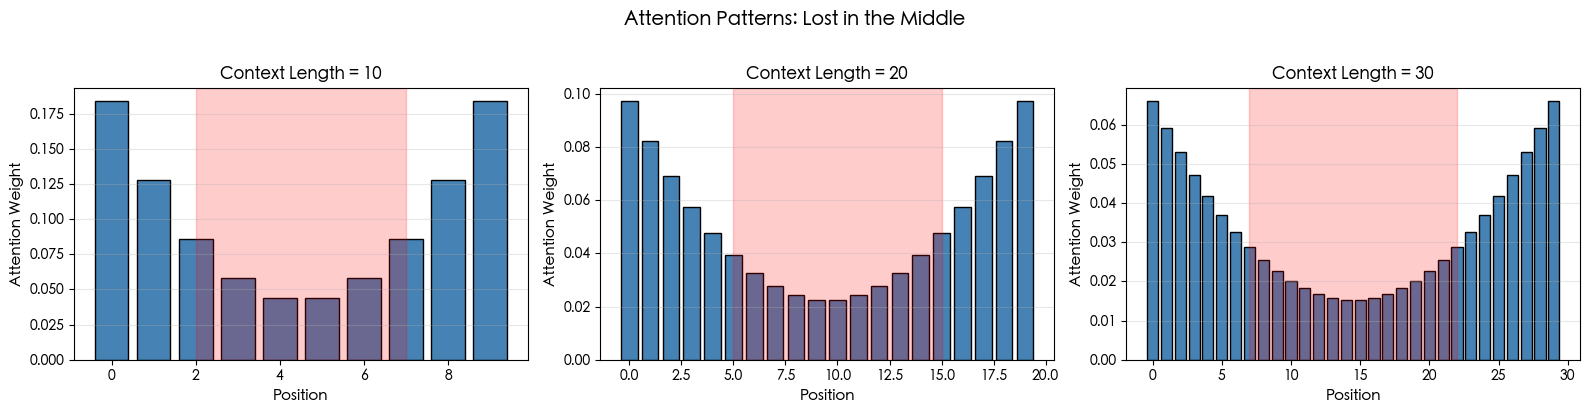


随着上下文增长，中间位置获得的注意力更少！


In [7]:
# 模拟不同上下文长度的注意力模式
context_lengths = [10, 20, 30]
fig, axes = plt.subplots(1, 3, figsize=(16, 4))

for ax, length in zip(axes, context_lengths):
    # 生成注意力权重（U 型）
    positions = np.arange(length)
    normalized = positions / (length - 1)
    attention = 4 * (normalized - 0.5) ** 2 + 0.3
    attention = attention / np.sum(attention)
    
    # 绘制
    ax.bar(positions, attention, color='steelblue', edgecolor='black', linewidth=1)
    ax.set_xlabel('Position', fontsize=11)
    ax.set_ylabel('Attention Weight', fontsize=11)
    ax.set_title(f'Context Length = {length}', fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3, axis='y')
    
    # 高亮中间区域
    middle_start = length // 4
    middle_end = 3 * length // 4
    ax.axvspan(middle_start, middle_end, alpha=0.2, color='red')

plt.suptitle('Attention Patterns: Lost in the Middle', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print("\n随着上下文增长，中间位置获得的注意力更少！")

## 关键要点

### 迷失在中间现象：

**观察**：语言模型显示 **U 型性能曲线**
- ✅ 相关信息在**开始**时准确率高
- ✅ 相关信息在**结束**时准确率高  
- ❌ 相关信息在**中间**时准确率**低**

### 为什么会发生这种情况？

**假设**：

1. **注意力模式**：
   - 自注意力自然关注最近的 token（近因偏差）
   - 也关注早期的 token（首因偏差）
   - 中间的 token 获得较少的注意力

2. **训练分布**：
   - 大多数训练文档都很短
   - 长上下文在预训练中很少见
   - 模型没有学会很好地使用中间部分

3. **因果掩码**：
   - Decoder 模型无法"向前看"
   - 中间的信息可能被后续 token"覆盖"

### 实验结果：

**来自论文**：

**多文档 QA**：
- 相关文档在位置 1（开始）：~90% 准确率
- 相关文档在位置 5（中间）：~60% 准确率  
- 相关文档在位置 10（结束）：~85% 准确率

**上下文长度的影响**：
- 10 个文档：中间惩罚 ~30%
- 20 个文档：中间惩罚 ~40%
- 30 个文档：中间惩罚 ~50%

**测试的模型**：
- GPT-3.5-turbo：强 U 型偏差
- Claude：强 U 型偏差
- GPT-4：有所缓解但仍存在
- 开源 LLM：偏差更强

### 位置偏差公式：

位置 $p$（归一化 0-1）的性能：
$$
\text{Accuracy}(p) \propto 4(p - 0.5)^2 + c
$$

其中：
- 最小值在 $p = 0.5$（中间）
- 最大值在 $p = 0$ 和 $p = 1$（边缘）
- $c$ 是基线性能

### 对 RAG 系统的影响：

**问题**：
```
检索器返回: [Doc1, Doc2, ..., Doc20]
            (按相关性分数排序)

如果最相关的文档在中间 → 性能差！
```

**解决方案**：

1. **重新排序检索到的文档**：
   - 将最相关的放在开始
   - 或交错：最佳在边缘，最差在中间

2. **限制上下文长度**：
   - 使用更少、更相关的文档
   - Top-3 或 top-5 而不是 top-20

3. **分块**：
   - 将长上下文分成较小的块处理
   - 聚合结果

4. **显式注意力**：
   - 微调模型以关注中间
   - 添加抵消偏差的位置嵌入

### 文档排序策略：

| 策略 | 描述 | 性能 |
|----------|-------------|-------------|
| 检索顺序 | 保持检索顺序 | 基线 |
| 最相关优先 | 最佳在开始 | 良好 |
| 最相关边缘 | 最佳在开始和结束 | **最佳** |
| 反转 | 反转检索顺序 | 变化 |

### 最佳实践：

1. **尽可能使用短上下文**
2. **重要信息放在边缘**（开始或结束）
3. **在传递给 LLM 之前重排序**文档
4. **分块**处理非常长的上下文
5. **测试**模型的位置敏感性

### 代码示例（重新排序）：

```python
def reorder_for_llm(docs, scores):
    """将最相关的放在边缘"""
    sorted_idx = np.argsort(scores)[::-1]
    
    # 交错高相关性和低相关性
    reordered = []
    for i in range(len(docs) // 2):
        reordered.append(docs[sorted_idx[i]])  # 高
    for i in range(len(docs) // 2, len(docs)):
        reordered.append(docs[sorted_idx[i]])  # 低
    
    # 也将最佳移到末尾
    mid = len(reordered) // 2
    return reordered[:mid] + reordered[mid:][::-1]
```

### 缓解策略：

**训练期间**：
- 包含长上下文示例
- 显式监督中间位置
- 使用位置感知目标

**推理期间**：
- 策略性地重新排序文档
- 使用多次传递（处理子集）
- 显式提示："同等关注所有文档"

**架构变更**：
- 稀疏注意力模式
- 分层处理
- 检索增强注意力

### 未来方向：

- **位置不变模型**：训练以忽略位置偏差
- **自适应注意力**：学习关注相关部分
- **分块处理**：在重叠窗口中处理
- **多遍推理**：多次读取上下文

### 要点信息：

```
⚠️  警告：不要假设 LLM 同等使用所有上下文！

✅  做：测试位置敏感性
✅  做：将重要信息放在边缘  
✅  做：尽可能保持上下文简短
❌  不做：假设中间位置工作良好
❌  不做：盲目连接许多文档
```

### 影响：

这篇论文揭示了当前 LLM 的关键局限性，并改变了我们对以下方面的思考：
- RAG 系统设计
- 长上下文评估
- QA 的文档排序
- 多源提示工程

**记住**：即使有 100k+ 的上下文窗口，位置仍然重要！